<a href="https://colab.research.google.com/github/peinadoginesd/analysis-bicimad-data/blob/main/bicimad_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análisis de datos: BiciMad**


---
Esencialmente, la idea que se ha seguido durante la elaboración de esta práctica y que ha ido cambiando a lo largo de su desarrollo consistía en hacer una distinción entre clases de las estaciones de bicicletas que la empresa BiciMad tiene repartidas por Madrid en función del uso que se hace de ellas. Hecho esto, se visualizarían algunas de las características que las hacen diferentes.

Sin embargo, a la vista de los resultados obtenidos y como se verá a continuación, hemos terminado redirigiendo este enfoque para finalmente hacer una clasificación no de las estaciones sino de los 365 días del año 2018, en base a los viajes que se hacen en estos días. Hemos conseguido una distinción bastante clara en tres tipos entre los cuales la distribución del consumo de BiciMad a lo largo de las 173 estaciones disponibles es sustacialmente distinta.

En la segunda parte de la práctica intentamos analizar por separado los viajes en los días más representativos de cada uno de estos tres grupos y comparar los resultados, para finalmente representar las diferencias que puedan existir entre ellos.

Antes de enfocar el tema principal, se realizaron algunos análisis superficiales del contenido de los datos, los cuales justifican ciertas decisiones adoptadas en lo sucesivo.

El total de viajes durante el año 2018 es de 3.678.086, de los cuales más del 90% son realizados por usuarios poseedores de un pase anual (usuarios tipo 1), poco más del 1.5% por usuarios ocasionales (tipo 2) y menos de un 0.0006% por clientes cuyo estatus no ha sido posible identificar (tipo 0).

No tendremos en cuenta estos últimos por carecer de parámetros clave como puede ser el rango de edad y representar una cantidad residual sobre el total. Tampoco consideramos los realizados por empleados de BiciMad (usuarios tipo 3).

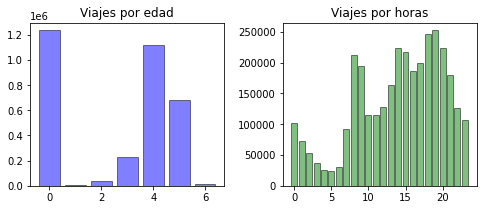

A grandes rasgos, la distribución de las horas en las que los viajes se realizan son muy similares para todas las clases de usuario.





# Preparación del entorno y **RUTA**

In [ ]:
!apt-get install openjdk-8-jdk
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!pip install pyspark

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-compute-11-1
  cuda-nsight-systems-10-1 cuda-nsight-systems-

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyspark import SparkContext
sc = SparkContext()

In [ ]:
PATH = '/content/drive/My Drive/bicimad-analysis' # RUTA DE LA CARPETA QUE CONTIENE TODOS LOS ARCHIVOS

# **Cargamos los datos del año 2018**
Se almacenan todos los viajes realizados entre el 1 de Enero de 2018 y el 1 de Enero de 2019 en una sola *RDD*.

In [ ]:
rdd_base = sc.textFile(PATH + '/201801_Usage_Bicimad.json')

for month in range(2,13):

    dataFile = sc.textFile(PATH + '/2018' + str(month).zfill(2) + '_Usage_Bicimad.json')
    
    rdd_base = rdd_base.union(dataFile)

A continuación, se extraen los datos necesarios para esta primera parte de la práctica mapeando  *rdd_base*, obteniendo así: estación de **salida**, **fecha** y **hora** y **tipo de usuario**.

Con el fin de caracterizar de forma más precisa el comportamiento de cada estación,  se filtran los datos, manteniendo sólo los viajes que cumplen las siguientes condiciones:

*   Viajes comprendidos entre las 5:00 y las 10:00 horas.
*   Viajes realizados por usuarios anuales u ocasionales.

La limitación en la franja horaria tiene el objetivo de ceñir el análisis a los desplazamientos hacia el lugar de trabajo/estudio.

In [ ]:
import json as json
import datetime as dt


def mapper(line):
    
    data = json.loads(line)
    
    out = data['idunplug_station']
    date_ = data['unplug_hourTime']['$date'][0:10]
    date = tuple(map(int, date_.split('-')))  # Obtenemos tupla con año, mes y día.
    hour = int(data['unplug_hourTime']['$date'][11:13])
    userType = data['user_type']
    ageRange = data['ageRange']

    return out, (dt.datetime(date[0], date[1], date[2]), hour), userType


def filt(data, day=None):
    
    hour = data[1][1]
    userType = data[2]
    selected_day = True if (day == None or day == data[1][0]) else False
    
    return hour in range(5,10) and (userType == 1 or userType == 2) and selected_day


rdd = rdd_base.map(mapper).filter(filt).map(lambda x: (x[0], x[1][0]))

Mediante algunas transformaciones, se agrupan las salidas que se efectúan en cada estación para cada día del año, obteniendo una matriz X. Esta matriz, de dimensiones 173x365, recoge la evolución temporal de las salidas efectuadas en cada una de las 173 estaciones a lo largo del año 2018. Eliminamos una fila, correspondiente a una extraña estación número 2008 con un solo viaje, y una columna, correspondiente al día 1 de Enero de 2019 incluido entre los datos de Diciembre de 2018.

Cabe mencionar que se obtienen 172 estaciones; no obstante, la número 22, 68 y 70 no presentan salidas ni llegadas (por motivos desconocidos); se concluye por lo tanto que realmente se disponen de las estaciones desde la 1 hasta la número 175, faltando las tres mencionadas anteriormente.

In [ ]:
import numpy as np


lista_fechas = [dt.datetime(2018,1,1) + dt.timedelta(days=d) for d in range(366)] # lista con días del año

# Creamos un diccionario modelo con todos los días del año.
d_model = {}
for day in lista_fechas:
    d_model[day] = 0

# Para cada estación, devuelve una lista con las salidas que se han hecho desde ellas en cada día del año (después de un groupByKey()).
def trip_day(line):
  d = d_model.copy()
  for x in line:
    d[x] += 1
  return list(d.values())


l = rdd.groupByKey().mapValues(trip_day).sortBy(lambda x: x[0]).flatMap(lambda x: x[1]).collect()
X = np.array(l).reshape(173,len(lista_fechas))[:-1,:-1]

# **Principal Component Analysis (PCA)**
El Análisis de Componentes Principales es una técnica de aprendizaje no supervisado muy útil en el análisis de datos que tiene como objetivo describir un conjunto grande de variables en términos de un nuevo número menor de variables o componentes principales, combinación lineal de las originales y no correladas. De esta forma, se hace posible desde representar espacialmente los datos y extraer conclusiones de ellos, hasta identificar patrones y
variables latentes, así como descifrar relaciones entre ellas o aplicar otras técnicas como el clustering.

Como se dijo en la introducción, la idea que teníamos y que llevamos a cab al principio, consistía en usar el algoritmo PCA para resumir las 365 variables de cada estación en un número menor de componentes principales que expliquen suficiente varianza.
Posteriormente, con algún algoritmo de clasificación (KMeans ó DBSCAN), intentamos hacer una clasificación de las estaciones. Los resultados obtenidos, que se pueden visualizar en la imagen de abajo, no fueron concluyentes, o no conseguimos sacar una interpretación clara de ellos.

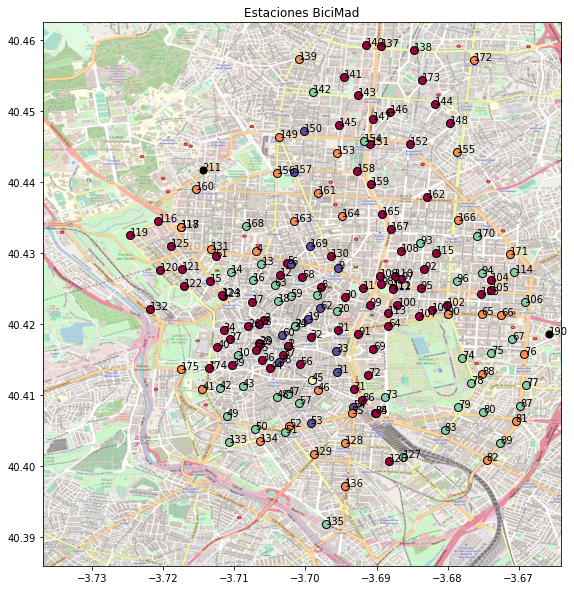

En consecuencia, decidimos reinterpretar el problema y considerar cada día del año con 172 "variables estaciones". A continuación, aplicamos el PCA de este modo para obtener dos componentes principales y posteriormente clasificar los días del año en función de estas dos componentes. Más adelante se observará como, de esta manera, se consigue que las dos componentes principales expliquen mayor varianza que con la interpretación anterior.

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.sql import SparkSession
from pyspark.ml.feature import PCA

# Creamos un dataframme con los 173 vectores de longitud 365.
spark = SparkSession.builder.getOrCreate()
L = [(Vectors.dense(X[row]),) for row in range(len(X))]
df = spark.createDataFrame(L,["features"])

# Aplicamos el PCA obteniendo 5 componentes, aunque nos quedandaremos con 2.
n_components = 5

pca = PCA(k=n_components, inputCol="features", outputCol="pca_features")
model = pca.fit(df)
A = model.transform(df).collect()

# Almacenamos las PC en un array.
components = model.pc
componentsArray = components.toArray()

# Dimensión del nuevo conjunto de variables.
print(componentsArray.shape)

(365, 5)


Se mira la proporción de varianza explicada acumulada para diferente números de componentes.

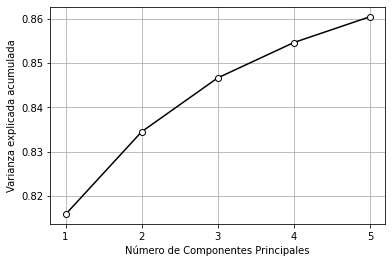

In [ ]:
import matplotlib.pyplot as plt

# Creamos una lista con las proporciones de varianza para los números de componentes.
explained_variance = model.explainedVariance
acumulate_variance = [sum(explained_variance[:j+1]) for j in range (len(explained_variance))]

# Representamos gráficamente.
fig = plt.figure()
plt.plot(np.arange(1,n_components+1), acumulate_variance, ls='-',color='k',
         marker='o', mec='k', mfc='w')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza explicada acumulada')
plt.xticks(np.arange(1,n_components+1))
plt.grid()
plt.show()

Como se aprecia en la gráfica anterior, las dos primeras componentes acumulan aproximadamente un 83% de la varianza total, por lo que, a priori, podemos afirmar que éstas caracterizan nuestro conjunto de datos.
En las siguientes gráficas se puede visualizar el efecto que tienen las cuatro primeras PC sobre cada día del año.

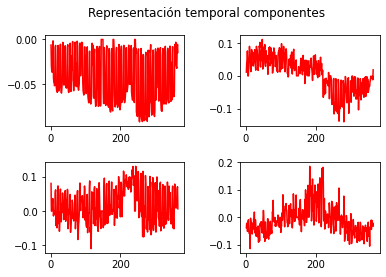

In [ ]:
# REPRESENTACIÓN TEMPORAL 4 COMPONENTES.
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 4+1):
    ax = fig.add_subplot(2, 2, i)
    plt.plot(np.arange(1,366), componentsArray[:,i-1], c='r')
plt.suptitle('Representación temporal componentes')
plt.show()

# **KMeans**
Para clasificar los días del año se ha probado con dos algoritmos diferentes de clustering: KMeans y DBSCAN. Finalmente optamos por el algoritmo de KMeans, basado en la elección de centroides y la técnica de los mínimos cuadrados, ya que ofrecía mejores resultados.



Text(0, 0.5, 'Segunda Componente')

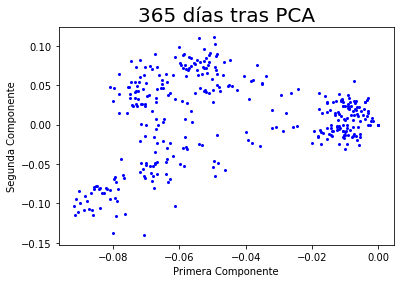

In [ ]:
plt.plot(componentsArray[:,0], componentsArray[:,1], 'bo', markersize=2)
plt.title('365 días tras PCA', fontsize=20)
plt.xlabel('Primera Componente')
plt.ylabel('Segunda Componente')

En primer lugar, se realiza un análisis de Silhouette (similar al que se expone en el tutorial de la librería sklearn: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) para determinar cuál es el número de clusters que se adecúa mejor al conjunto de datos que tenemos. Finalmente, se elige k = 3 como número óptimo de clusters, ya que, además de tener el coeficiente de Silhouette más elevado, las vecindades tienen un tamaño similar y, en general, los elementos presentan un coeficiente cercano a la media.

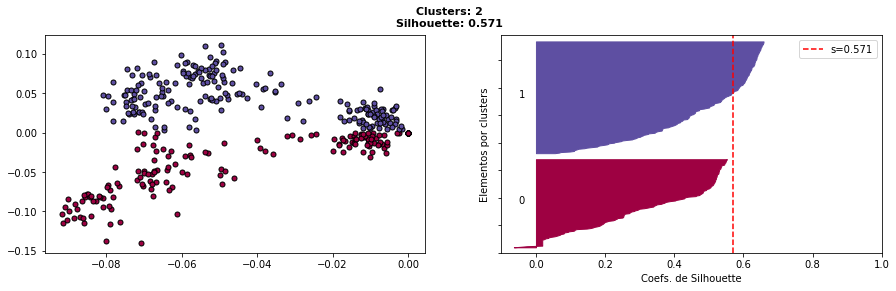

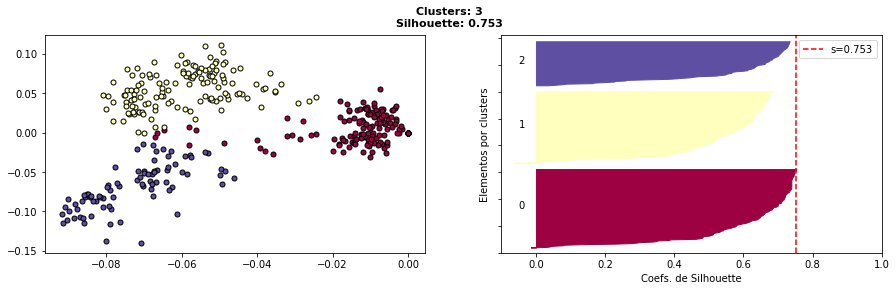

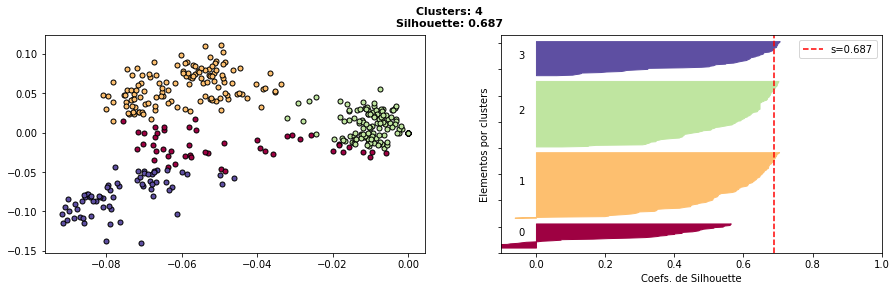

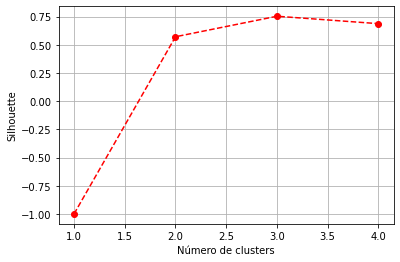

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from sklearn import metrics


componentsArray = componentsArray[:,:2]
evaluator = ClusteringEvaluator()
L = [(Vectors.dense(componentsArray[i]),) for i in range(len(componentsArray))]
df = spark.createDataFrame(L,["features"])


n_clusters_posibles, silhouette_values = np.arange(1,5), [-1]

for n_clusters in n_clusters_posibles[1:]:

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
  
    kmeans = KMeans().setK(n_clusters).setSeed(1)
    model = kmeans.fit(df)
    predictions = model.transform(df)
    labels = np.array(list(map(lambda x: tuple(x)[0], predictions.select('prediction').collect())))

    silhouette = evaluator.evaluate(predictions)
    silhouette_values.append(silhouette)
    elements_silhouette = metrics.silhouette_samples(componentsArray, labels) # coef. de Silh. para cada muestra
    
    y_lower = 10 # coordenada y de inicio de la franja correspondiente al cluster
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    for k, col in zip(unique_labels, colors):

        xy = componentsArray[labels == k]

        # Tomamos los coefs. de Silhouette de cada elemento del cluster y ordenamos
        xy_elements_silhouette = elements_silhouette[labels==k]
        xy_elements_silhouette.sort() 

        y_upper = y_lower + len(xy) # coordenada y del final de la franja
        
        ax1.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), 
                 markeredgecolor='k', markersize=5)
        ax2.fill_betweenx(np.arange(y_lower, y_upper), 0, xy_elements_silhouette, 
                          facecolor=tuple(col), edgecolor=tuple(col), alpha=1)   
        
        ax2.text(-0.05, y_lower + 0.5 * len(xy), str(k))
        
        y_lower = y_upper + 10 
    
    ax2.axvline(silhouette, color="red", linestyle="--", lw=1.5)
    ax2.legend(['s=%0.3f' % silhouette])
    ax2.set(xlabel='Coefs. de Silhouette', ylabel='Elementos por clusters',
            yticklabels=([]), 
            xlim=[-0.1,1], ylim=[0, len(componentsArray) + (n_clusters + 1)*10])
    
    plt.suptitle('Clusters: %s\nSilhouette: %0.3f'
                 % (n_clusters, silhouette), fontsize=11, fontweight='bold')
    plt.show()


fig, ax = plt.subplots()
ax.plot(n_clusters_posibles, silhouette_values, 'ro--')
ax.set(xlabel='Número de clusters', ylabel='Silhouette')
ax.grid()
plt.show()

Aplicamos el algoritmo KMeans con k = 3 y visualizamos los resultados.

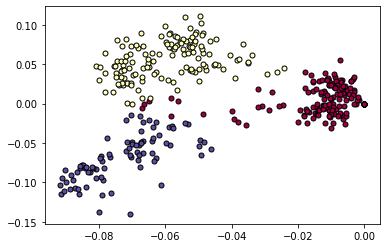

[array([-0.01325248,  0.004988  ]), array([-0.05940911,  0.05545467]), array([-0.0728613 , -0.06887433])]


In [ ]:
kmeans = KMeans().setK(3).setSeed(1)
model = kmeans.fit(df)
predictions = model.transform(df)

labels = np.array(list(map(lambda x: tuple(x)[0], predictions.select('prediction').collect()))) # lista con cluster asignado a cada día del año
centroids = model.clusterCenters()


unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
  
    xy = componentsArray[:,0:2][labels == k]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=5, zorder=0)

plt.show()


print(centroids)

In [ ]:
for day, group in zip(lista_fechas, labels):
  print(day, '-->', group)

2018-01-01 00:00:00 --> 0
2018-01-02 00:00:00 --> 1
2018-01-03 00:00:00 --> 1
2018-01-04 00:00:00 --> 1
2018-01-05 00:00:00 --> 1
2018-01-06 00:00:00 --> 0
2018-01-07 00:00:00 --> 0
2018-01-08 00:00:00 --> 1
2018-01-09 00:00:00 --> 1
2018-01-10 00:00:00 --> 1
2018-01-11 00:00:00 --> 1
2018-01-12 00:00:00 --> 1
2018-01-13 00:00:00 --> 0
2018-01-14 00:00:00 --> 0
2018-01-15 00:00:00 --> 1
2018-01-16 00:00:00 --> 1
2018-01-17 00:00:00 --> 1
2018-01-18 00:00:00 --> 1
2018-01-19 00:00:00 --> 1
2018-01-20 00:00:00 --> 0
2018-01-21 00:00:00 --> 0
2018-01-22 00:00:00 --> 1
2018-01-23 00:00:00 --> 1
2018-01-24 00:00:00 --> 1
2018-01-25 00:00:00 --> 1
2018-01-26 00:00:00 --> 1
2018-01-27 00:00:00 --> 0
2018-01-28 00:00:00 --> 0
2018-01-29 00:00:00 --> 1
2018-01-30 00:00:00 --> 1
2018-01-31 00:00:00 --> 1
2018-02-01 00:00:00 --> 1
2018-02-02 00:00:00 --> 1
2018-02-03 00:00:00 --> 0
2018-02-04 00:00:00 --> 0
2018-02-05 00:00:00 --> 1
2018-02-06 00:00:00 --> 1
2018-02-07 00:00:00 --> 1
2018-02-08 0

La lista labels recoge las asignaciones que el algoritmo ha dado a cada día del año de forma ordenada. El primer día se corresponde con el Lunes 1 de Enero de 2018 y así sucesivamente.

La asignación de los fines de semana y días festivos en los dos primeros tercios del año al cluster 0 se identifica como un patrón claro, mientras que los días laborables son asignados al cluster 1. En cuanto al cluster 2, aparece por primera vez un Lunes 18 de Junio, día a partir del cual empieza a ser usual su aparición junto a días laborables.

# **Obtención de los 3 días más representativos de cada cluster**
A partir de los centroides de cada uno de los clusters, se calculan las distancias de cada día a éstos, obteniendo así el día que más próximo esté a cada centroide. Estos tres días pueden ser considerados los más representativos de cada uno de los tipos y son los que se estudiarán a continuación.

In [ ]:
from scipy.spatial import distance


DAYS = []

for cent in centroids:
  
  day = 0
  distMin = distance.euclidean(componentsArray[day], cent)
  
  for k in range(1, len(componentsArray)):
    dist = distance.euclidean(componentsArray[k], cent)
    if dist < distMin:
      distMin = dist
      day = k
  
  DAYS.append(lista_fechas[day])


print(DAYS)

[datetime.datetime(2018, 7, 21, 0, 0), datetime.datetime(2018, 4, 23, 0, 0), datetime.datetime(2018, 8, 28, 0, 0)]


#**Análisis de los 3 días más representativos**
Una vez que habíamos obtenido todo lo anterior nos propusimos sacar algo más de información de las estaciones en los días obtenidos al calcular los centroides de cada grupo, visto anteriormente.

Para la representación de los datos utilizaremos como herramienta fundamental un diccionario que a cada número de estación le asigna sus coordenadas geográficas. Lo construiremos con un archivo modificado de los datos de situación de las estaciones, al cual hemos dejado únicamente la primera fila ya que solo nos interesan las coordenadas de las estaciones.

In [ ]:
import json
def stat(line):
  data = json.loads(line)
  if ('stations' in data):
    estaciones = {}
    for estacion in data['stations']:
      estaciones[estacion['id']] = (float(estacion['longitude']),float(estacion['latitude']))
    return estaciones

estaciones_dict = sc.textFile(PATH + '/estaciones_bicimad.json').map(stat).first()

## **Número de viajes por estación**

En primer lugar visualizamos los tres días en base al número de salidas que se efectúan en las estaciones mediante un cmap. Cargamos de nuevo los datos específicos de los meses que vamos a usar para reducir el tiempo de ejecución.

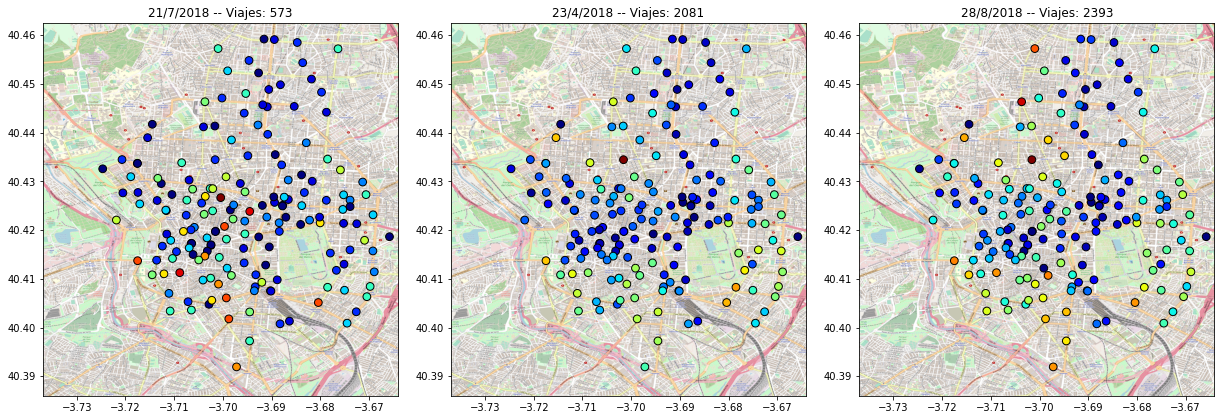

In [ ]:
BBox = (-3.7370, -3.6641, 40.3860, 40.4625)
mapa = plt.imread(PATH + '/map.png')
coords = np.array(list(estaciones_dict.values()))[:176]

fig = plt.figure(figsize=(21,7.45))
fig.subplots_adjust(hspace=0.0, wspace=0.15)

for i in range(1, 4):
  
  day_dict = sc.textFile(PATH + '/2018' + str(DAYS[i-1].month).zfill(2) + '_Usage_Bicimad.json').map(mapper).filter(lambda _: filt(_, day=DAYS[i-1])).countByKey()

  viajes = {}
  for key in estaciones_dict:
    
    try:
      viajes[key] = day_dict[key]
    
    except KeyError:
      viajes[key] = 0
 
  ax = fig.add_subplot(1, 3, i)
  ax.scatter(coords[:,0], coords[:,1], c=list(viajes.values()), cmap='jet', s=60, edgecolors='k')

  ax.set_title(str(DAYS[i-1].day)+'/'+str(DAYS[i-1].month)+'/'+str(DAYS[i-1].year)+' -- Viajes: '+str(sum(viajes.values())))
  ax.set_xlim(BBox[0],BBox[1])
  ax.set_ylim(BBox[2],BBox[3])  
  ax.imshow(mapa, zorder=0, extent = BBox, aspect= 'equal')

plt.show()

## **Clasificación por la distancia media**

Una primera idea para clasificar todas las estaciones fue calcular el número de estaciones que se encuentran ''cerca'' de cada una de ellas. Entendiendo por cerca de una estación determinada todas aquellas que están dentro de un cierto radio de distancia. Este radio que vamos a establecer para medir la proximidad entre las estaciones será un cuarto de la media de las distancias que se recorren en los trayectos que tienen como destino la estación determinada. Es decir, si se quiere calcular cuántas estaciones están ''cerca'' de la estación número 10, con las distancias de todos los trayectos que tienen como destino la estación 10 se hallará la media; así, todas las estaciones que estén dentro de un radio de (media)/4, cogiendo como centro la estación 10, se considerarán como cerca.

In [ ]:
rdd_abril = sc.textFile(PATH + '/201804_Usage_Bicimad.json')
rdd_julio = sc.textFile(PATH + '/201807_Usage_Bicimad.json')
rdd_agosto = sc.textFile(PATH + '/201808_Usage_Bicimad.json')

Creamos un mapper que nos busca las entradas, salidas, el tiempo que dura el trayecto, el tipo de usuario, y el rango de edad.

In [ ]:
import datetime as dt
import json as json
import numpy as np

def mapper2(line):
  data = json.loads(line)
  out = data['idunplug_station']
  end = data['idplug_station']
  date_ = data['unplug_hourTime']['$date'][0:10]
  hour = int(data['unplug_hourTime']['$date'][11:13])
  date = tuple(map(int, date_.split('-')))
  userType = data['user_type']
  travelTime = data['travel_time']
  ageRange = data['ageRange']

  return out, end, dt.datetime(date[0], date[1], date[2]), hour, travelTime, userType, ageRange

Las siguientes funciones sirven para mapear la rdd; así, *trayectos* sirve para obtener las estaciones de salida y llegada de cada trayecto, mientras que *filtro* toma sólo las coordenadas en las que se sitúa cada estación. 

In [ ]:
import json 
def trayectos(line): 
    data = line
    return data[0],data[1]
  
def filtro(line):
    if 'id' in line or 'latitude'  in line or 'longitude' in line:
       if 'address'  in line or 'name' in line:
          return False
       return True   
    else:
      return False

Se busca la distancia entre dos puntos (con latitud y longitud) dados. 

In [ ]:
import math
def distanciametros(lat1,lat2,lon1,lon2):
    lon1 = math.radians(lon1)
    lon2 = math.radians(lon2)
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)
    alo =  lon2-lon1
    alat = lat2-lat1
    a = (math.sin((alat/2))**2) + math.cos(lat1) * math.cos(lat2) * ((math.sin(alo/2))**2)
    R = 6378
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R * c
    return d

Con la función anterior, se obtiene en el siguiente mapeo la tupla formada por la estación a la que se llega y la distancia a la que se encuentra de la estación desde la que se inicia el recorrido. 

In [ ]:
import math
def distancias(line):
    data = (line)
    est_sali = data[0]
    est_llega = data[1]
    try:
      lat1 = estaciones_dict[est_llega][0]
      lon1 = estaciones_dict[est_llega][1]
      lat2 = estaciones_dict[est_sali][0]
      lon2 = estaciones_dict[est_sali][1]
      distancia  = distanciametros(lat1,lat2,lon1,lon2)
      return est_llega,distancia
    except:
      return est_llega,0

Se cuentan el número de estaciones que están a distancia menor que un cuarto de la media previamente calculada. 

In [ ]:
def contarestaci(line):
    est_llega = line[0]
    cont = 0
    for i in range(174):
      if  i != est_llega:
       est_sali = i 
       try:
         lat1 = estaciones_dict[est_llega][0]
         lon1 = estaciones_dict[est_llega][1]
         lat2 = estaciones_dict[est_sali][0]
         lon2 = estaciones_dict[est_sali][1]
         distancia  = distanciametros(lat1,lat2,lon1,lon2)
       except:
         continue
       if distancia < (line[1]/4):   
         cont = cont +1
    return est_llega,cont

Con los días que ya se habían fijado, se calculan las rdd's con el número de estaciones que se encuentran cerca de ellas.

Creamos diccionarios con estos datos para cada día.

In [ ]:
from statistics import mean

dic1 = rdd_julio.map(mapper2).filter(lambda x: x[2] == DAYS[0]).map(trayectos).map(distancias).groupByKey().mapValues(mean).map(contarestaci).collectAsMap()
dic2 = rdd_abril.map(mapper2).filter(lambda x: x[2] == DAYS[1]).map(trayectos).map(distancias).groupByKey().mapValues(mean).map(contarestaci).collectAsMap()
dic3 = rdd_agosto.map(mapper2).filter(lambda x: x[2] == DAYS[2]).map(trayectos).map(distancias).groupByKey().mapValues(mean).map(contarestaci).collectAsMap()
#El diccionarioi dic1 tiene en número de estaciones que están cerca de cada una basándose en los trayectos del día 21 de julio.
#El diccionarioi dic2 tiene en número de estaciones que están cerca de cada una basándose en los trayectos del día 23 de abril.
#El diccionarioi dic3 tiene en número de estaciones que están cerca de cada una basándose en los trayectos del día 28 de agosto.

Representamos gráficamente:

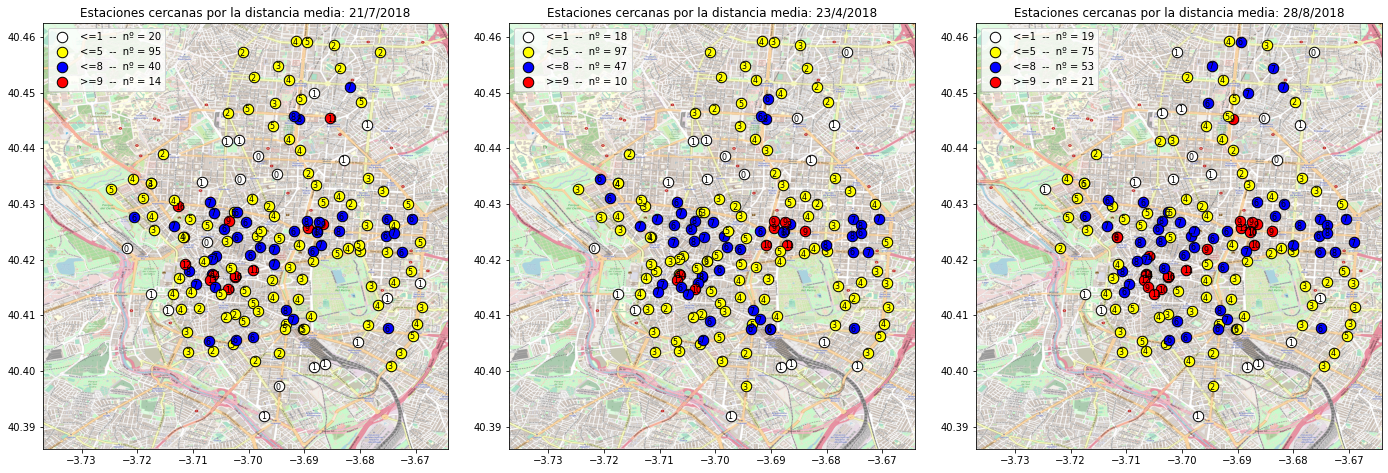

In [ ]:
import matplotlib.pyplot as plt

BBox = (-3.7370, -3.6641, 40.3860, 40.4625)
mapa = plt.imread(PATH + '/map.png')
fig = plt.figure(figsize=(24,10))
fig.subplots_adjust(hspace=0.0, wspace=0.15)

for i in range(1,4):

  if i==1:
    dic = dic1
  elif i==2:
    dic = dic2
  else:
    dic = dic3

  ax = fig.add_subplot(1, 3, i)
  ax.set_title('Estaciones cercanas por la distancia media: ' + str(DAYS[i - 1].day) + '/' + str(DAYS[i - 1].month) + '/' + str(DAYS[i - 1].year))
  ax.set_xlim(BBox[0],BBox[1])
  ax.set_ylim(BBox[2],BBox[3])  
  ax.imshow(mapa, zorder=0, extent = BBox, aspect= 'equal')

  count = [0,0,0,0]

  for (numero, coord) in estaciones_dict.items():
    try:
      if dic[numero] <= 1:
        ax.scatter(coord[0], coord[1], c='white', zorder=1, s=110, edgecolors='k')
        ax.annotate(str(dic[numero]),(coord[0]-0.0006,coord[1]-0.0006),fontsize=8)
        count[0]+=1
      elif dic[numero] <= 5: 
        ax.scatter(coord[0], coord[1], c='yellow', zorder=1, s=110, edgecolors='k')
        ax.annotate(str(dic[numero]),(coord[0]-0.0006,coord[1]-0.0006),fontsize=8)
        count[1]+=1
      elif dic[numero] <= 8: 
        ax.scatter(coord[0], coord[1], c='blue', zorder=1, s=110, edgecolors='k')
        ax.annotate(str(dic[numero]),(coord[0]-0.0006,coord[1]-0.0006),fontsize=8)
        count[2]+=1
      elif dic[numero] >= 9: 
        ax.scatter(coord[0], coord[1], c='red', zorder=1, s=110, edgecolors='k')
        ax.annotate(str(dic[numero]),(coord[0]-0.0006,coord[1]-0.0006),fontsize=8)
        count[3]+=1
    except KeyError:
      continue
  ax.scatter(200, 200, c='white', zorder=1, s=110, edgecolors='k',label='<=1  --  nº = '+str(count[0]))
  ax.scatter(200, 200, c='yellow', zorder=1, s=110, edgecolors='k',label='<=5  --  nº = '+str(count[1]))
  ax.scatter(200, 200, c='blue', zorder=1, s=110, edgecolors='k',label='<=8  --  nº = '+str(count[2]))
  ax.scatter(200, 200, c='red', zorder=1, s=110, edgecolors='k',label='>=9  --  nº = '+str(count[3]))
  ax.legend(loc="upper left") 
plt.show()

Vemos que el día de agosto es el que nos encontramos con más estaciones  con mayor número de estaciones cercanas, luego podemos suponer que en vacaciones los usuarios recorren trayectos más largos, haciendo que la media de la distancias aumente.

Además, el día con más estaciones con pocas estaciones cercanas es en julio muy seguido de agosto, pues en abril se hacen más trayectos.

Por último, cabe destacar, que en los rangos medios con estaciones cercanas entre 2 y 8, vuelve a ponerse en cabeza abril, pues como decíamos, un día de diario tiene más trayectos aunque menos recorrido que en festivos.

##**Análisis por rango de edad**

Otra manera de analizar las estaciones es comprobar qué rango de edad predomina en su uso. De este modo podemos observar en cierta medida los rangos de edad más habituales en las distintas zonas de Madrid.

Para lograr esto primero definimos dos nuevas funciones para mapear a los datos, una para obtener las salidas de las estaciones por rango de edad y otra para las llegadas. Así al unirlas tendremos la información de salidas o llegadas por rango de edad. Una vez hecho esto deberemos filtrar para cada dia representativo para poder visualizar la información realtiva a estos dias.


In [ ]:
def salidas(line):
  data = json.loads(line)
  #comprobamos que los identificadores estan en los datos para que no haya errores.
  if ('idunplug_station' and 'ageRange' and 'unplug_hourTime' and 'user_type') in data:
    dia = int(data['unplug_hourTime']['$date'][8:10])
    #comprobamos que el usuario sea relevante
    if data['user_type'] != 0 and data['user_type'] != 3:
      #agrupamos los rangos de edad mas jovenes
      if data['ageRange'] == 1 or data['ageRange'] == 2 or data['ageRange'] == 3:
        return data['idplug_station'], 3, dia
      elif data['ageRange'] != 0:
        return data['idplug_station'], data['ageRange'], dia

def llegadas(line):
  data = json.loads(line)
  #comprobamos que los identificadores estan en los datos para que no haya errores.
  if ('idplug_station' and 'ageRange' and 'unplug_hourTime' and 'user_type') in data:
    dia = int(data['unplug_hourTime']['$date'][8:10])
    #comprobamos que el usuario sea relevante
    if data['user_type'] != 0 and data['user_type'] != 3:
      #agrupamos los rangos de edad mas jovenes
      if data['ageRange'] == 1 or data['ageRange'] == 2 or data['ageRange'] == 3:
        return data['idplug_station'], 3, dia
      elif data['ageRange'] != 0:
        return data['idplug_station'], data['ageRange'], dia

Una vez hemos obtenido los rdd correspondientes debemos agruparlos por estaciones y dejando como valor una lista con todos los rangos de edad que aparecen para esa estación y así la moda de esta lista será el valor que buscamos.

Debido a que la funcion *mode* de la libreria *statistics* falla cuando el elemento más repetido no es único, debemos realizar una función para contemplar este hecho.

Dado que la franja de edad que más viajes realiza es la 4 hemos decidido que en caso de empate esta tendrá menos prioridad, de tal forma que daremos mayor prioridad al rango de edad que menos viajes haya realizado ese día.

In [ ]:
from statistics import mode
from collections import Counter
def moda(lista):
  try:
    return mode(lista)
  except:
    data = Counter(lista)
    repetidos = list(filter(lambda x: x[1] == data.most_common(1)[0][1],data.most_common()))
    rango_min = repetidos[0][0]
    for (rango, apariciones) in repetidos:
      if datos_uso[rango] < datos_uso[rango_min]:
        rango_min = rango
    print(rango_min)
    lista.append(rango_min)
    print(lista)
    return mode(lista)

Por último realizamos la representación de los datos mediante un mapa de la comunidad de Madrid, generando tres imagenes que en las que vienen representadas la estaciones de un color diferente en función de su rango de edad asignado.

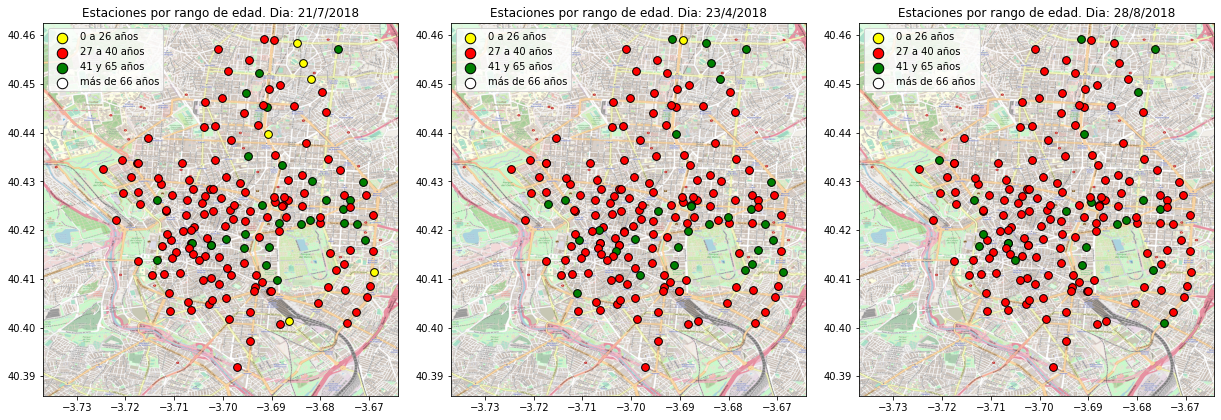

In [ ]:
import matplotlib.pyplot as plt
BBox = (-3.7370, -3.6641, 40.3860, 40.4625)
mapa = plt.imread(PATH + '/map.png')
fig = plt.figure(figsize=(21,7.45))
fig.subplots_adjust(hspace=0.0, wspace=0.15)

for i in range(1,4):

  #leemos los datos de uso por salidas y llegadas a cada estacion en los dias representativos y los unimos en un rdd
  est_sal = sc.textFile(PATH + '/2018' + str(DAYS[i-1].month).zfill(2) + '_Usage_Bicimad.json').map(salidas).filter(lambda x: x!= None).filter(lambda x : x[2] == DAYS[i - 1].day)
  est_dest = sc.textFile(PATH + '/2018' + str(DAYS[i-1].month).zfill(2) + '_Usage_Bicimad.json').map(llegadas).filter(lambda x: x!= None).filter(lambda x : x[2] == DAYS[i - 1].day)
  datos_est = sc.union([est_sal,est_dest])

  #construyo un diccionario que a cada franja de edad le asigna el numero de viajes del dia
  datos_uso = datos_est.map(lambda x: (x[1],x[0]))
  datos_uso = datos_uso.countByKey()
  #convertimos los datos en un diccionario que a cada estacion le asigna el rango de edad que mas la usa
  datos_est = datos_est.map(lambda x: (x[0],x[1]))
  edad_estacion = datos_est.groupByKey().mapValues(list).mapValues(moda)
  dict_edad_estacion = edad_estacion.collectAsMap()


  ax = fig.add_subplot(1, 3, i)
  ax.set_title('Estaciones por rango de edad. Dia: ' + str(DAYS[i - 1].day) + '/' + str(DAYS[i - 1].month) + '/' + str(DAYS[i - 1].year))
  ax.set_xlim(BBox[0],BBox[1])
  ax.set_ylim(BBox[2],BBox[3])  
  ax.imshow(mapa, zorder=0, extent = BBox, aspect= 'equal')

  ax.scatter(200, 200, c='yellow', zorder=1, s=110, edgecolors='k',label='0 a 26 años')
  ax.scatter(200, 200, c='red', zorder=1, s=110, edgecolors='k',label='27 a 40 años')
  ax.scatter(200, 200, c='green', zorder=1, s=110, edgecolors='k',label='41 y 65 años')
  ax.scatter(200, 200, c='white', zorder=1, s=110, edgecolors='k',label='más de 66 años')

  for (numero, coord) in estaciones_dict.items():
    try:
      if dict_edad_estacion[numero] == 3: # 0 a 26 años
        ax.scatter(coord[0], coord[1], c='yellow', zorder=1, s=60, edgecolors='k')
      elif dict_edad_estacion[numero] == 4: # 27 a 40 años
        ax.scatter(coord[0], coord[1], c='red', zorder=1, s=60, edgecolors='k')
      elif dict_edad_estacion[numero] == 5: # 41 y 65 años 
        ax.scatter(coord[0], coord[1], c='green', zorder=1, s=60, edgecolors='k')
      elif dict_edad_estacion[numero] == 6: # mas de 66 años
        ax.scatter(coord[0], coord[1], c='white', zorder=1, s=60, edgecolors='k')
    except KeyError:
      continue
  ax.legend(loc="upper left") 

plt.show()

Se puede observar que el primer día (que es representativo de un día festivo) aparecen algunas estaciones con rango de edad "joven" seguramente debido a que los trayectos asociados a trabajadores tienen menos impacto. 

En las otras imagenes observamos un claro dominio de las franjas de edad más características de los trabajadores, fundamentalmente entre 27 y 40 años.

También se observa la ausencia del grupo de personas mayores de 66 años, resultado esperable dado el bajo número de viajes realizados por ese rango.

# **Conclusiones**

Con respecto a los resultados obtenidos, se pueden sacar varias conclusiones:

Es necesario hacer un análisis previo de los datos que se vayan a utilizar pues pueden presentar una serie de irregularidades. Sin ir más lejos, en esta práctica empezamos utilizando el archivo Excel de relación de estaciones de BICIMAD y su codificación presente en la página web oficial y que finalmente no pudimos utilizar debido a que presentaba errores como estaciones repetidas o sin coordenadas. A causa de esto, terminamos utilizando el archivo "situación estaciones BICIMAD por día y hora de junio de 2019" modificado para reducir el coste en memoria.

Observando la distribución de los viajes a lo largo de las estaciones en días festivos y fines de semana, concluímos que aumenta el uso recreativo de BICIMAD ya que se aprecia un mayor uso por parte de usuarios jóvenes y las distancias recorridas son mayores.

Respecto a los días laborables, el algoritmo KMeans devuelve una distinción entre los días de la primera mitad del año y la segunda. Sin embargo, no hemos encontrado una razón clara para explicar este suceso ya que hay demasiadas variables involucradas.